# <font color = 'indianred'>**MultiClass Classification with DistilBert** </font>


## Outline
1. **Setting up the Environment**: Installing necessary libraries and setting up paths.
2. **Creating Huggingface Dataset for Custom Dataset**: Understanding the structure and content of the dataset.

3. **Data Preprocessing**: Techniques to prepare the data for training, including handling different data splits and tokenization
4. **Training the Model**: Feeding data and adjusting weights.
5. **Inference**: Evaluate model on test set and making predictions.



# <font color = 'indianred'> **Setting up the Environment** </font>



In [121]:
 # CHANGE FOLDERS AS PER YOUR SETUP
from pathlib import Path
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount("/content/drive")
    !pip install datasets transformers evaluate wandb accelerate -U -qq
    base_folder = Path("/content/drive/MyDrive/data")
else:
    base_folder = Path("/home/harpreet/Insync/google_drive_shaannoor/data")


from transformers import AutoConfig, AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments
from transformers import AutoTokenizer, DataCollatorWithPadding, pipeline
from datasets import load_dataset, DatasetDict, Dataset, ClassLabel
import evaluate

import torch
from torch.utils.data import DataLoader

import wandb

import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import random

import textwrap

In [122]:
# CHANGE FOLDERS TO WHERE YOU WANT TO SAVE DATA AND MODELS
data_folder = base_folder/'datasets/Classification_HW/csv_files'
model_folder = base_folder/'models/nlp_fall_2023/HW5'
model_folder.mkdir(exist_ok=True)

In [123]:
def print_wrap(text, d):
    # Wrap the text to limit the width to 'd'
    wrapped_text = textwrap.fill(text, width=d)

    # Print the wrapped text
    print(wrapped_text)

# <font color = 'indianred'> **Exploring and Understanding Dataset**

## <font color = 'indianred'> **Stack Exchange MultiClass Dataset**</font>

- In this HW, you will identify tags for stack exchange Questions.
- This data is a subset of data available in a Kaggle Competition.
- The given dataset has different questions asked in the StackExchange website for various technical domains.
- We have fetched only those questions that contain the top 10 individual tags.
- **Each question has only one tag. This means that this is a <font color = "indianred">multi-class classification problem.**</font>
- These are the ten categories for tags in the data.

<div style="margin-left:5%">


| Index| Tag  |
|:-------:|:-------------:|
| 0     | C#          |
| 1     | java        |
| 2     | php         |
| 3     | javascript  |
| 4     | android     |
| 5     | jquery      |
| 6     | c++         |
| 7     | python      |
| 8     | iphone      |
| 9     | asp.net     |

</div>

## <font color = 'indianred'> **Load Data set**
    


In [124]:
# The file 'multiclass_hw_basic_clean.csv' is availaible on eLearing 0_data_Folder
# Make sure that you specify teh correct path
# The file name need to be in teh string, thaat is why we have used str(file_path)
# We loaded imdb dataset from huggingface
# in this case we are creating a hugginmgface dataset from csv file
stack_dataset = load_dataset('csv', data_files= str(data_folder /'multiclass_hw_basic_clean.csv'))

## <font color = 'indianred'> **Understanding your data**

In [125]:
print(stack_dataset)

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0.1', 'Unnamed: 0', 'Title', 'Body', 'cleaned_text', 'Tags', 'Tag_Number_final', 'combined_text', 'basic_cleaned_text'],
        num_rows: 188878
    })
})


## <font color = 'indianred'> **Understanding the datatype of columns**


In [126]:
stack_dataset['train'].features


{'Unnamed: 0.1': Value(dtype='int64', id=None),
 'Unnamed: 0': Value(dtype='int64', id=None),
 'Title': Value(dtype='string', id=None),
 'Body': Value(dtype='string', id=None),
 'cleaned_text': Value(dtype='string', id=None),
 'Tags': Value(dtype='string', id=None),
 'Tag_Number_final': Value(dtype='int64', id=None),
 'combined_text': Value(dtype='string', id=None),
 'basic_cleaned_text': Value(dtype='string', id=None)}

 - As you can see the dataset has lot of faeatures. However they are not all useful.
 - Title is the title of the stack exchange post
 - Body is the main text of the post
 - combined_text is Title and Body combined with no pre-processing
 - basic_cleaned_text is Title and Body combined with basic preprocessing (remove html tags, urls, emails).
 - cleaned_text - Here we have combined Body and Text and has done some motre pre-propcessing in addition to basic (removing stopwords, lammetization)
 - Tags - names of programming language to which the post belongs
 - Tag_Number_final - index corresponding to Tags

 - **Your goal in this HW is to predict Tags given Body and Title of the post**
 - **You will use Tag_Number_final and basic_cleaned_text for this HW**


## <font color = 'indianred'> **Acess indivdual element** </font>


In [127]:
# get the first example of the dataset
stack_dataset['train'][1]


{'Unnamed: 0.1': 1,
 'Unnamed: 0': 1,
 'Title': 'hello world fails to show up in emulator',
 'Body': "<p>I followed Hello World tutorial exactly.  Emulator comes up but fails to show Hello World text.  Here's the log info:</p>\n\n<pre><code>[2011-11-26 20:06:57 - HelloAndroid] Android Launch!\n[2011-11-26 20:06:57 - HelloAndroid] adb is running normally.\n[2011-11-26 20:06:57 - HelloAndroid] Performing com.example.helloandroid.HelloAndroid activity launch\n[2011-11-26 20:06:57 - HelloAndroid] Automatic Target Mode: launching new emulator with compatible AVD 'AndroidPhone'\n[2011-11-26 20:06:57 - HelloAndroid] Launching a new emulator with Virtual Device 'AndroidPhone'\n[2011-11-26 20:07:09 - HelloAndroid] New emulator found: emulator-5554\n[2011-11-26 20:07:09 - HelloAndroid] Waiting for HOME ('android.process.acore') to be launched...\n[2011-11-26 20:45:37 - HelloAndroid] HOME is up on device 'emulator-5554'\n[2011-11-26 20:45:37 - HelloAndroid] Uploading HelloAndroid.apk onto device 

In [128]:
print_wrap(stack_dataset['train']['Body'][0], 80)

<p>Is there a simple way to place a detail disclosure icon on a UIButton? I'm
using a navigation controller and I want a button press to push a new view on
the stack, so I thought a detail disclosure icon would be appropriate, but I
haven't found a straightforward way to do that yet.</p>  <p>What I have in mind
is something like the "When Timer Ends" button in the Timer subview of the Clock
app.</p>


In [129]:
print_wrap(stack_dataset['train']['combined_text'][0], 80)

detail disclosure indicator on UIButton <p>Is there a simple way to place a
detail disclosure icon on a UIButton? I'm using a navigation controller and I
want a button press to push a new view on the stack, so I thought a detail
disclosure icon would be appropriate, but I haven't found a straightforward way
to do that yet.</p>  <p>What I have in mind is something like the "When Timer
Ends" button in the Timer subview of the Clock app.</p>


In [130]:
print_wrap(stack_dataset['train']['cleaned_text'][0], 80)

detail disclosure indicator uibutton simple way place detail disclosure icon
uibutton navigation controller want button press push new view stack think
detail disclosure icon appropriate find straightforward way mind like timer ends
button timer subview clock app


In [131]:
print_wrap(stack_dataset['train']['basic_cleaned_text'][0], 80)

detail disclosure indicator on UIButton Is there a simple way to place a detail
disclosure icon on a UIButton? I'm using a navigation controller and I want a
button press to push a new view on the stack, so I thought a detail disclosure
icon would be appropriate, but I haven't found a straightforward way to do that
yet. What I have in mind is something like the "When Timer Ends" button in the
Timer subview of the Clock app.


In [132]:
stack_dataset['train'].features

{'Unnamed: 0.1': Value(dtype='int64', id=None),
 'Unnamed: 0': Value(dtype='int64', id=None),
 'Title': Value(dtype='string', id=None),
 'Body': Value(dtype='string', id=None),
 'cleaned_text': Value(dtype='string', id=None),
 'Tags': Value(dtype='string', id=None),
 'Tag_Number_final': Value(dtype='int64', id=None),
 'combined_text': Value(dtype='string', id=None),
 'basic_cleaned_text': Value(dtype='string', id=None)}

In [133]:
# get label of last ten examples
stack_dataset['train']['Tag_Number_final'][-10:]

[4, 4, 9, 5, 5, 4, 7, 3, 4, 2]

In [134]:
# Assuming 'stack_dataset' is a huggingface dataset
# Select only the desired columns and rename them
selected_columns = {
    'text': stack_dataset['train']['basic_cleaned_text'],
    'label': stack_dataset['train']['Tag_Number_final']
}

# Create a new dataset with the selected columns
stack_selected_columns = Dataset.from_dict(selected_columns)


In [135]:
stack_selected_columns

Dataset({
    features: ['text', 'label'],
    num_rows: 188878
})

In [136]:
stack_selected_columns.features

{'text': Value(dtype='string', id=None),
 'label': Value(dtype='int64', id=None)}

In [137]:
stack_selected_columns['label'][:10]

[8, 4, 3, 9, 4, 0, 3, 2, 0, 7]

In [138]:
print_wrap(stack_selected_columns['text'][0], 80)

detail disclosure indicator on UIButton Is there a simple way to place a detail
disclosure icon on a UIButton? I'm using a navigation controller and I want a
button press to push a new view on the stack, so I thought a detail disclosure
icon would be appropriate, but I haven't found a straightforward way to do that
yet. What I have in mind is something like the "When Timer Ends" button in the
Timer subview of the Clock app.


## <font color = 'indianred'> **Exploratory Data Analysis (EDA)**

### <font color = 'indianred'> **Change dataset format to Pandas**  </font>


In [139]:
# Set the format to Pandas
stack_selected_columns.set_format(type='pandas') # CODE HERE

In [140]:
# get all rows the dataset
df = stack_selected_columns[:]


In [141]:
df.head()

,text,label
0,detail disclosure indicator on UIButton Is the...,8
1,hello world fails to show up in emulator I fol...,4
2,"Why is JSHint throwing a ""possible strict viol...",3
3,Programmatically Make Bound Column Invisible I...,9
4,"More than one EditText - not getting focus, no...",4


In [142]:
# DO NOT RUN THIS CELL

In [143]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188878 entries, 0 to 188877
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    188874 non-null  object
 1   label   188878 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.9+ MB


In [144]:
# DO NOT RUN THIS CELL

### <font color = 'indianred'> **Visualize distribution of class labels** </font>
It is important to undetrstand the distribution of the class labels to check if there is any imbalance among the categories.

<Axes: ylabel='label'>

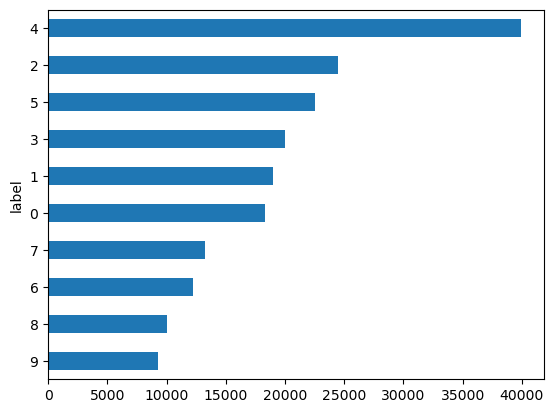

In [145]:
# check distribution of class labels in the dataset
df['label'].value_counts(ascending=True).plot.barh() # CODE HERE

### <font color = 'indianred'> **Check length of the reviews** </font>


In [146]:
# Add empty strings for rows atht do not have any text
df['text'] = df['text'].fillna('')

In [147]:
# Calculate words per review
df['words_per_review'] = df['text'].str.split().apply(len) # CODE HERE


In [148]:
df.head()

,text,label,words_per_review
0,detail disclosure indicator on UIButton Is the...,8,80
1,hello world fails to show up in emulator I fol...,4,256
2,"Why is JSHint throwing a ""possible strict viol...",3,40
3,Programmatically Make Bound Column Invisible I...,9,60
4,"More than one EditText - not getting focus, no...",4,197


#### <font color = 'indianred'> **Plot the distribution of review length** </font>

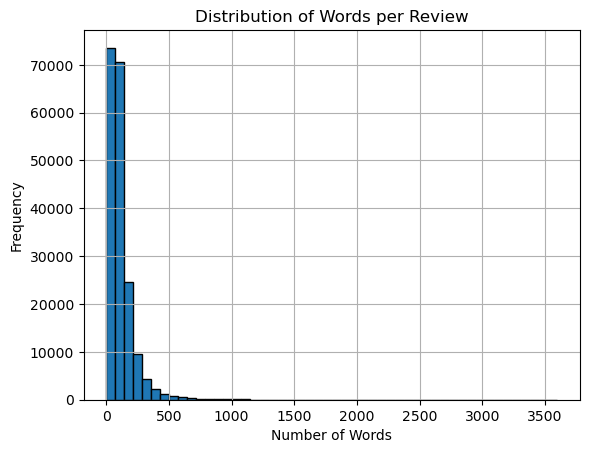

In [149]:
# Plot a histogram of the 'words_per_review' column
df['words_per_review'].hist(bins=50, edgecolor='black')

# Adding labels and a title for clarity
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.title('Distribution of Words per Review')

# Display the plot
plt.show()


In [150]:
# The model we are going to use has token (subwords) limit of 512.
# Let us check how many reviews has more than 500 words

count = (df['words_per_review'] > 500).sum()
print(f"Number of reviews with more than 400 words: {count}")


Number of reviews with more than 400 words: 2653


In [151]:
# count the rows that do not have any text
count = (df['words_per_review'] ==0).sum()
print(f"Number of reviews with no text words: {count}")

Number of reviews with no text words: 4


In [152]:
# check the rows that have less than 20 words
count = (df['words_per_review'] <20).sum()
print(f"Number of reviews with less than 20 words: {count}")

Number of reviews with less than 20 words: 2208


<Axes: title={'center': 'words_per_review'}, xlabel='label'>

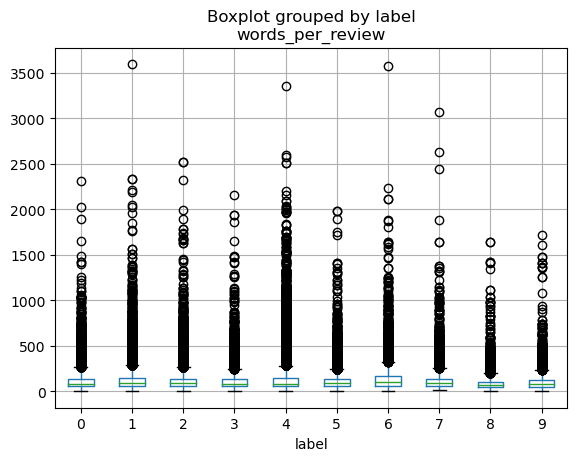

In [153]:
# distribution of number of words for each class label
df.boxplot('words_per_review', by='label')


- From the above graph, it seems that the distribution of number of words is similar for all the classes.
- Most models have max sequence length of 512. We have less than 1% observatins that have more than 512 words.

### <font color = 'indianred'> **Reset dataset format** </font>


In [154]:
# reset teh format back to huggingface dataset
stack_selected_columns.reset_format() # CODE HERE


In [155]:
stack_selected_columns

Dataset({
    features: ['text', 'label'],
    num_rows: 188878
})

# <font color = 'indianred'> **Data Pre-processing**</font>

### <font color = 'indianred'> **Create train, valid, test splits** </font>

In [156]:
# We know this information from how we created this dataset
class_names = ['c#', 'java', 'php','javascript', 'android', 'jquery', 'c++',  'python', 'iphone', 'asp.net']

In [157]:
# Cast the 'label' column of stack_selected_columns to the ClassLabel type with specified class names from class_names.
stack_selected_columns = stack_selected_columns.cast_column('label', ClassLabel(names = class_names))


Casting the dataset:   0%|          | 0/188878 [00:00<?, ? examples/s]

The code above modifies the label column of the stack_selected_columns data structure to represent categorical data using the class names provided in class_names. This will help us to keep the index and names mapping together.

In [158]:
stack_selected_columns.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['c#', 'java', 'php', 'javascript', 'android', 'jquery', 'c++', 'python', 'iphone', 'asp.net'], id=None)}

In [159]:
stack_selected_columns

Dataset({
    features: ['text', 'label'],
    num_rows: 188878
})

In [160]:
# Split the test set into test and validation sets
# The train set should  be 60% of the daatset, valid and test should be 20% each
test_val_splits = stack_selected_columns.train_test_split(test_size=0.4, seed=42, stratify_by_column='label') 
train_split= test_val_splits['train'] 
test_val_splits = test_val_splits['test'].train_test_split(test_size=0.5, seed=42, stratify_by_column='label') 
val_split = test_val_splits['train'] 
test_split = test_val_splits['test'] 


In [161]:
# take a subset for each split
train_split = train_split.shuffle(seed = 42).select(range(2000))
val_split = val_split.shuffle(seed = 42).select(range(2000))
test_split = test_split.shuffle(seed = 42).select(range(2000))


In [162]:
# combine train, val splits into one dataset
train_val_subset= DatasetDict({'train': train_split, 'val': val_split})

# create test dataset from test split
test_subset = DatasetDict({'test': test_split})



### <font color = 'indianred'> **Create small subset for experimentation** </font>

The code below creates a new dataset, train_val_subset, with subsets of the original train_val_dataset. For each split ('train' and 'val'), it ensures an equal representation of 200 samples from each label (0-9). The balanced subsets are then stored in the respective splits of train_val_subset.

In [163]:
# train_val_subset = DatasetDict()

# for split in ['train', 'val']:
#   texts = []
#   labels = []
#   for label in range(10):
#     label_texts = train_val_dataset[split].filter(lambda x: x['label'] == label)['text']
#     label_subset = random.sample(list(label_texts), 200)
#     texts.extend(label_subset)
#     labels.extend([label]*len(label_subset))

#   train_val_subset[split] = Dataset.from_dict({'text': texts, 'label': labels})

In [164]:
# Set the format of the train_val_subset to be a pandas DataFrame for easier data manipulation and analysis.
train_val_subset.set_format(type='pandas')


In [165]:
train_val_subset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    val: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

<Axes: ylabel='label'>

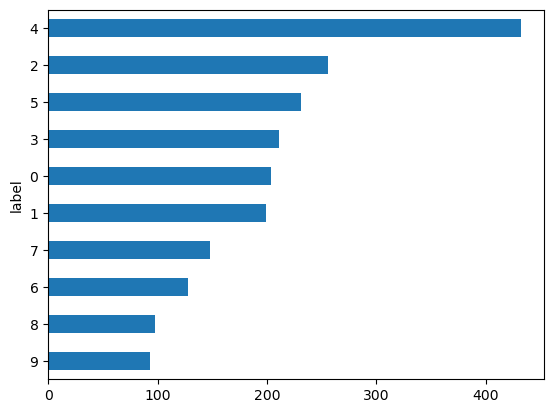

In [166]:
# Plot a horizontal bar chart of the count of each label in the 'train' split of train_val_subset, in ascending order.
train_val_subset['train']['label'].value_counts(ascending=True).plot.barh() # CODE HERE


<Axes: ylabel='label'>

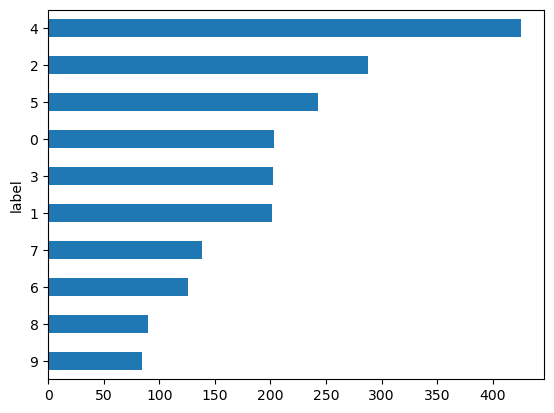

In [167]:
# Plot a horizontal bar chart of the count of each label in the 'val' split of train_val_subset, in ascending order.
train_val_subset['val']['label'].value_counts(ascending=True).plot.barh() 


In [168]:
# Reset the format of train_val_subset to its original huggingface format
train_val_subset.reset_format()


In [169]:
# Retrieve the feature structures (data types and associated details) of the 'train' split from train_val_subset.
train_val_subset['train'].features


{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['c#', 'java', 'php', 'javascript', 'android', 'jquery', 'c++', 'python', 'iphone', 'asp.net'], id=None)}

In [170]:
# Cast the 'label' column of the entire train_val_subset to the ClassLabel type using the provided class names from class_names.
train_val_subset = train_val_subset.cast_column('label', ClassLabel(names = class_names)) # CODE HERE


Casting the dataset:   0%|          | 0/2000 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [171]:
train_val_subset['train'].features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['c#', 'java', 'php', 'javascript', 'android', 'jquery', 'c++', 'python', 'iphone', 'asp.net'], id=None)}

## <font color = 'indianred'> **Tokenization**</font>



In [172]:
# Define a checkpoint for the DistilBERT model with an uncased vocabulary.
# Instantiate the tokenizer for this model using the specified checkpoint.
checkpoint = "distilbert-base-uncased" # CODE HERE
tokenizer = AutoTokenizer.from_pretrained(checkpoint) # CODE HERE



###  <font color = 'indianred'> **Understanding pre-trained Tokenizer**
We will now understand how the tokenizer work by feeding one simple example.

In [173]:
text = ["Tokenization is the process of splitting sequence to tokens",
        "I like BUAN6482"]

In [174]:
# get the vocab size
print(f'Pretrained tokenizer vocab size {tokenizer.vocab_size}')


Pretrained tokenizer vocab size 30522


In [175]:
encoded_text = tokenizer(
    text, padding=True, truncation=True, return_tensors='pt')

In [176]:
encoded_text

{'input_ids': tensor([[  101, 19204,  3989,  2003,  1996,  2832,  1997, 14541,  5537,  2000,
         19204,  2015,   102],
        [  101,  1045,  2066, 20934,  2319, 21084,  2620,  2475,   102,     0,
             0,     0,     0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0]])}

What is the difference from ```bert-base-uncased``` tokenizer?

- ```distilbert-base-uncased``` do not have token-type-ids

In [177]:
tokens_first_sentence = tokenizer.convert_ids_to_tokens(
    encoded_text.input_ids[0])
tokens_second_sentence = tokenizer.convert_ids_to_tokens(
    encoded_text.input_ids[1])

print(tokens_first_sentence)
print(tokens_second_sentence)

['[CLS]', 'token', '##ization', 'is', 'the', 'process', 'of', 'splitting', 'sequence', 'to', 'token', '##s', '[SEP]']
['[CLS]', 'i', 'like', 'bu', '##an', '##64', '##8', '##2', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


In [178]:
tokenizer.convert_tokens_to_string(tokens_first_sentence)

'[CLS] tokenization is the process of splitting sequence to tokens [SEP]'

In [179]:
tokenizer.convert_tokens_to_string(tokens_second_sentence)

'[CLS] i like buan6482 [SEP] [PAD] [PAD] [PAD] [PAD]'

In [180]:
special_tokens = tokenizer.all_special_tokens
special_tokens_ids = tokenizer.all_special_ids
print(special_tokens, special_tokens_ids)

['[UNK]', '[SEP]', '[PAD]', '[CLS]', '[MASK]'] [100, 102, 0, 101, 103]


###  <font color = 'indianred'> **Create function for Tokenizer**

In [181]:
# Define a function to tokenize the text in a batch using the predefined tokenizer.
# The text data is extracted from the "text" key of the batch.
# The function will truncate the tokenized data if it exceeds the tokenizer's maximum length.

def tokenize_fn(batch):
    return tokenizer(batch["text"], truncation=True)


###  <font color = 'indianred'> **Use map function to apply tokenization to all splits**

In [182]:
# Map the tokenize_fn function over the entire train_val_subset dataset in batches.
# This will tokenize the text data in each batch and return a new dataset with tokenized data.
tokenized_dataset = train_val_subset.map(tokenize_fn, batched=True) # CODE HERE


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [183]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
    val: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
})

In [184]:
# DO NOT RUN THIS CELL

We can see that tokenization step has added three new columns ('input_ids', 'token_type_ids', 'attention_mask') to the dataset

In [185]:
tokenized_dataset = tokenized_dataset.remove_columns(
    ['text']
)

In [186]:
tokenized_dataset.set_format(type='torch')

In [187]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
    val: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
})

In [188]:
tokenized_dataset['train'].features

{'label': ClassLabel(names=['c#', 'java', 'php', 'javascript', 'android', 'jquery', 'c++', 'python', 'iphone', 'asp.net'], id=None),
 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}

In [189]:
print(len(tokenized_dataset["train"]["input_ids"][2]))
print(len(tokenized_dataset["train"]["input_ids"][1]))

98
84


The varying lengths in the dataset indicate that padding has not been applied yet. Instead of padding the entire dataset, we prefer processing small batches during training. Padding is done selectively for each batch based on the maximum length in the batch. We will discuss this in more detail in a later section of this notebook.

#  <font color = 'indianred'> **Model Training**

##  <font color = 'indianred'> **Model Config File**

###  <font color = 'indianred'> **Download config file of pre-trained Model**</font>



In [190]:
# Load the configuration associated with the specified checkpoint (e.g., DistilBERT model configuration).
# This configuration contains details about the model architecture and settings.
# use Autoconfig class
config = AutoConfig.from_pretrained(checkpoint) # CODE HERE



In [191]:
config

DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.30.2",
  "vocab_size": 30522
}

###  <font color = 'indianred'> **Modify Configuration File**</font>
- We need to modify configuration fie to add ids to  label and label to ids mapping
- Adding id2label and label2id to the configuration file provides a consistent, interpretable, and user-friendly way to handle model outputs.

In [192]:
class_names = tokenized_dataset["train"].features["label"].names
class_names


['c#',
 'java',
 'php',
 'javascript',
 'android',
 'jquery',
 'c++',
 'python',
 'iphone',
 'asp.net']

In [193]:
id2label = {}
for id_, label_ in enumerate(class_names):
    id2label[str(id_)] = label_
id2label


{'0': 'c#',
 '1': 'java',
 '2': 'php',
 '3': 'javascript',
 '4': 'android',
 '5': 'jquery',
 '6': 'c++',
 '7': 'python',
 '8': 'iphone',
 '9': 'asp.net'}

In [194]:
label2id = {}
for id_, label_ in enumerate(class_names):
    label2id[label_] = id_
label2id


{'c#': 0,
 'java': 1,
 'php': 2,
 'javascript': 3,
 'android': 4,
 'jquery': 5,
 'c++': 6,
 'python': 7,
 'iphone': 8,
 'asp.net': 9}

In [195]:
config.id2label = id2label
config.label2id = label2id

In [196]:
config


DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "c#",
    "1": "java",
    "2": "php",
    "3": "javascript",
    "4": "android",
    "5": "jquery",
    "6": "c++",
    "7": "python",
    "8": "iphone",
    "9": "asp.net"
  },
  "initializer_range": 0.02,
  "label2id": {
    "android": 4,
    "asp.net": 9,
    "c#": 0,
    "c++": 6,
    "iphone": 8,
    "java": 1,
    "javascript": 3,
    "jquery": 5,
    "php": 2,
    "python": 7
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.30.2",
  "vocab_size": 30522
}

##  <font color = 'indianred'> **Download pre-trained model**

In [197]:
# Instantiate a model for sequence classification using the specified checkpoint.
# The provided configuration (config) ensures the model aligns with the structure and settings of the original checkpoint.
# Use AutoModelForSequenceClassification
# Pass the checkpoint and config
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, config=config) # CODE HERE


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.weight', 'classifier.bias', 'pre_classifier.we

## <font color = 'indianred'> **Model Input/Collate Function** </font>

In [198]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [199]:
features = [tokenized_dataset["train"][i] for i in range(2)]

In [200]:
features

[{'label': tensor(2),
  'input_ids': tensor([  101, 25718,  6276,  2039,  1037,  3058,  2000, 19274,  2046,  4249,
           1045,  2031,  1037,  2492,  1999,  2026,  7809,  2170,  1005,  3058,
           1035,  2794,  1005,  1012,  1012,  1012,  2009,  2003,  1037, 13075,
           7507,  2099,  5930,  1006,  1045,  2113, 13075,  7507,  2099,  3475,
           2102,  2157,  1010,  2021,  2049,  1996,  2126,  2009,  2001,  2328,
           1007,  1012,  1012,  1012,  2043,  1045, 14817,  1996,  3643,  2013,
           1996,  7809,  2009, 11204,  2009,  2004, 20315,  1011,  3461,  1011,
           1061,  2100,  2100,  2100,  2006,  1996,  2433,  2073,  1045, 14817,
           2009,  2000,  1010,  2045,  2024,  1022,  2235,  3793,  4249,  2008,
           2342,  2000,  2022,  3561,  2007,  2169,  1997,  1996,  5300,  1010,
           2061,  2028,  3793,  2492,  2097,  2031,  1996,  2034,  1040,  1010,
           1996,  2117,  2492,  2097,  2031,  1996,  2117,  1040,  1010,  1996,
     

In [201]:
model_input = data_collator(features)
model_input.keys()

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


dict_keys(['input_ids', 'attention_mask', 'labels'])

In [202]:
print(model_input.input_ids[0][0:10])
print(model_input.input_ids[0][-20:])
print(model_input.input_ids[1][0:10])
print(model_input.input_ids[1][-20:])

tensor([  101, 25718,  6276,  2039,  1037,  3058,  2000, 19274,  2046,  4249])
tensor([ 1049,  1012,  1012,  1012,  1998,  2061,  2006,  1012,  2129,  2052,
         1045,  2175,  2055,  2725,  2023,  1029, 21250,  2015,  1010,   102])
tensor([  101, 13752,  2019,  4064,  2862,  1045,  2074,  4384,  2008, 13752])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


In [203]:
print(model_input.attention_mask[0][-20:])
print(model_input.attention_mask[1][-20:])

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


In [204]:
print(tokenizer.convert_ids_to_tokens(model_input.input_ids[0][0:10]))

['[CLS]', 'php', 'cutting', 'up', 'a', 'date', 'to', 'insert', 'into', 'fields']


In [205]:
print(tokenizer.convert_ids_to_tokens(model_input.input_ids[0][-10:]))

['i', 'go', 'about', 'doing', 'this', '?', 'cheers', '##s', ',', '[SEP]']


In [206]:
print(tokenizer.convert_ids_to_tokens(model_input.input_ids[1][0:10]))

['[CLS]', 'declaring', 'an', 'empty', 'list', 'i', 'just', 'noticed', 'that', 'declaring']


In [207]:
print(tokenizer.convert_ids_to_tokens(model_input.input_ids[1][-10:]))

['[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


##  <font color = 'indianred'> **Understanding Model Output**

In [208]:
# model output
model=model.to(device=0)
model_input= model_input.to(device=0)
model.train()
model_output = model(**model_input)

In [209]:
# keys in model output
model_output.keys()

odict_keys(['loss', 'logits'])

In [210]:
# let us look at logits
model_output.logits


tensor([[ 0.0145, -0.1361,  0.0530,  0.0258, -0.0989, -0.0552,  0.0114, -0.0529,
          0.1601, -0.0448],
        [-0.1072, -0.0998,  0.0471, -0.0005, -0.1271, -0.0830,  0.0010, -0.0468,
          0.1234, -0.1681]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [211]:
model_output.logits.shape

torch.Size([2, 10])

In [212]:
model_output.loss

tensor(2.2737, device='cuda:0', grad_fn=<NllLossBackward0>)

##  <font color = 'indianred'> **Evaluation metric(s)** </font>

### <font color = 'indianred'> **Function to compute metric** </font>



In [213]:
# Define a function to compute evaluation metrics for sequence classification.
# The function takes in the evaluation predictions which consist of logits and true labels.
# The function calculates the macro F1 score and accuracy, and returns them as a dictionary.

def compute_metrics(eval_pred):
    # Split the evaluation predictions into logits (model predictions) and actual labels.
    logits, labels = eval_pred
    # Convert logits to class predictions by picking the class with the highest logit for each input.
    predictions = np.argmax(logits, axis=-1)

    # Load the macro F1 score metric.
    f1_metric = evaluate.load("f1", average="macro")
    # Load the accuracy metric.
    accuracy = evaluate.load("accuracy")

    # Initialize an empty dictionary to store computed metric results.
    evaluations = {}
    # Compute and store the macro F1 score.
    evaluations.update(f1_metric.compute(predictions=predictions, references=labels, average="macro"))
    # Compute and store the accuracy.
    evaluations.update(accuracy.compute(predictions=predictions, references=labels))

    return evaluations



## <font color = 'indianred'> **Set up Logger for experiments**</font>

In [213]:
# YOU WILL NEED TO CREATE AN ACCOUNT FOR WANDB
# It may provide a link for token , copy paste the token following instructions
# setup wandb
wandb.login()  # you will need to craete wandb account first
# Set project name for logging
%env WANDB_PROJECT = nlp_course_fall_2023-HW5-PartA

env: WANDB_PROJECT=nlp_course_fall_2023-HW5-PartA


## <font color = 'indianred'> **Hyperparameters and Checkpointing**</font>

In [214]:
# Define the directory where model checkpoints will be saved
model_folder = base_folder / "models"/"nlp_fall_2023/imdb/bert"
# Create the directory if it doesn't exist
model_folder.mkdir(exist_ok=True, parents=True)

# Configure training parameters
training_args = TrainingArguments(
    # Training-specific configurations
    num_train_epochs=2,  # Total number of training epochs
    # Number of samples per training batch for each device
    per_device_train_batch_size=16,
    # Number of samples per evaluation batch for each device
    per_device_eval_batch_size=16,
    weight_decay=0.01,  # Apply L2 regularization to prevent overfitting
    learning_rate=2e-5,  # Step size for the optimizer during training
    optim='adamw_torch',  # Optimizer,

    # Checkpoint saving and model evaluation settings
    output_dir=str(model_folder),  # Directory to save model checkpoints
    evaluation_strategy='steps',  # Evaluate model at specified step intervals
    eval_steps=20,  # Perform evaluation every 10 training steps
    save_strategy="steps",  # Save model checkpoint at specified step intervals
    save_steps=20,  # Save a model checkpoint every 10 training steps
    load_best_model_at_end=True,  # Reload the best model at the end of training
    save_total_limit=2,  # Retain only the best and the most recent model checkpoints
    # Use 'accuracy' as the metric to determine the best model
    metric_for_best_model="accuracy",
    greater_is_better=True,  # A model is 'better' if its accuracy is higher


    # Experiment logging configurations (commented out in this example)
    logging_strategy='steps',
    logging_steps=20,
    report_to='wandb',  # Log metrics and results to Weights & Biases platform
    run_name= 'stack_exp_imb_exp1',  # Experiment name for Weights & Biases
)


##  <font color = 'indianred'> **Initialize Trainer**</font>

In [215]:
# initialize trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["val"],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)


##  <font color = 'indianred'> **Start Training**

In [216]:
trainer.data_collator

DataCollatorWithPadding(tokenizer=DistilBertTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True), padding=True, max_length=None, pad_to_multiple_of=None, return_tensors='pt')

In [217]:
trainer.train()  # start training

  0%|          | 0/250 [00:00<?, ?it/s]

{'loss': 2.2419, 'learning_rate': 1.8400000000000003e-05, 'epoch': 0.16}


  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 2.168020486831665, 'eval_f1': 0.03506600660066007, 'eval_accuracy': 0.2125, 'eval_runtime': 20.8648, 'eval_samples_per_second': 95.855, 'eval_steps_per_second': 5.991, 'epoch': 0.16}
{'loss': 2.1171, 'learning_rate': 1.6800000000000002e-05, 'epoch': 0.32}


  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 1.9896785020828247, 'eval_f1': 0.289709903242611, 'eval_accuracy': 0.4815, 'eval_runtime': 20.8412, 'eval_samples_per_second': 95.964, 'eval_steps_per_second': 5.998, 'epoch': 0.32}
{'loss': 1.9488, 'learning_rate': 1.5200000000000002e-05, 'epoch': 0.48}


  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 1.7658761739730835, 'eval_f1': 0.3260963034417803, 'eval_accuracy': 0.5115, 'eval_runtime': 21.6098, 'eval_samples_per_second': 92.551, 'eval_steps_per_second': 5.784, 'epoch': 0.48}
{'loss': 1.6814, 'learning_rate': 1.3600000000000002e-05, 'epoch': 0.64}


  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 1.547851324081421, 'eval_f1': 0.3620380462163749, 'eval_accuracy': 0.5565, 'eval_runtime': 21.1633, 'eval_samples_per_second': 94.503, 'eval_steps_per_second': 5.906, 'epoch': 0.64}
{'loss': 1.4943, 'learning_rate': 1.2e-05, 'epoch': 0.8}


  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 1.376022458076477, 'eval_f1': 0.573418521315604, 'eval_accuracy': 0.7035, 'eval_runtime': 21.305, 'eval_samples_per_second': 93.875, 'eval_steps_per_second': 5.867, 'epoch': 0.8}
{'loss': 1.357, 'learning_rate': 1.04e-05, 'epoch': 0.96}


  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 1.2372807264328003, 'eval_f1': 0.6456550060012202, 'eval_accuracy': 0.7285, 'eval_runtime': 21.84, 'eval_samples_per_second': 91.575, 'eval_steps_per_second': 5.723, 'epoch': 0.96}
{'loss': 1.2191, 'learning_rate': 8.8e-06, 'epoch': 1.12}


  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 1.1121762990951538, 'eval_f1': 0.6910628709243999, 'eval_accuracy': 0.7705, 'eval_runtime': 21.6713, 'eval_samples_per_second': 92.288, 'eval_steps_per_second': 5.768, 'epoch': 1.12}
{'loss': 1.0846, 'learning_rate': 7.2000000000000005e-06, 'epoch': 1.28}


  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 1.0199027061462402, 'eval_f1': 0.6985082300155645, 'eval_accuracy': 0.774, 'eval_runtime': 21.4734, 'eval_samples_per_second': 93.139, 'eval_steps_per_second': 5.821, 'epoch': 1.28}
{'loss': 1.0725, 'learning_rate': 5.600000000000001e-06, 'epoch': 1.44}


  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 0.9643791913986206, 'eval_f1': 0.7477230851788568, 'eval_accuracy': 0.793, 'eval_runtime': 21.2657, 'eval_samples_per_second': 94.048, 'eval_steps_per_second': 5.878, 'epoch': 1.44}
{'loss': 1.0969, 'learning_rate': 4.000000000000001e-06, 'epoch': 1.6}


  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 0.9276591539382935, 'eval_f1': 0.752196856108218, 'eval_accuracy': 0.796, 'eval_runtime': 21.3439, 'eval_samples_per_second': 93.704, 'eval_steps_per_second': 5.856, 'epoch': 1.6}
{'loss': 0.9222, 'learning_rate': 2.4000000000000003e-06, 'epoch': 1.76}


  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 0.9051278233528137, 'eval_f1': 0.7665229247211002, 'eval_accuracy': 0.8005, 'eval_runtime': 21.372, 'eval_samples_per_second': 93.58, 'eval_steps_per_second': 5.849, 'epoch': 1.76}
{'loss': 1.0255, 'learning_rate': 8.000000000000001e-07, 'epoch': 1.92}


  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 0.8922208547592163, 'eval_f1': 0.7701544755298125, 'eval_accuracy': 0.8045, 'eval_runtime': 21.4307, 'eval_samples_per_second': 93.324, 'eval_steps_per_second': 5.833, 'epoch': 1.92}
{'train_runtime': 391.8202, 'train_samples_per_second': 10.209, 'train_steps_per_second': 0.638, 'train_loss': 1.4218112754821777, 'epoch': 2.0}


TrainOutput(global_step=250, training_loss=1.4218112754821777, metrics={'train_runtime': 391.8202, 'train_samples_per_second': 10.209, 'train_steps_per_second': 0.638, 'train_loss': 1.4218112754821777, 'epoch': 2.0})

## <font color = 'indianred'> **Evaluation**


### <font color = 'indianred'> **Check performance on validation set**</font>


In [218]:
# Evaluate the trained model on the tokenized validation dataset.
# This will provide metrics like loss, accuracy, etc. based on the model's performance on the validation set.
trainer.evaluate(tokenized_dataset["val"])


  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 0.8922208547592163,
 'eval_f1': 0.7701544755298125,
 'eval_accuracy': 0.8045,
 'eval_runtime': 21.518,
 'eval_samples_per_second': 92.945,
 'eval_steps_per_second': 5.809,
 'epoch': 2.0}

###  <font color = 'indianred'> **Check Confusion Matrix**</font>




In [219]:
# Use the trainer to generate predictions on the tokenized validation dataset.
# The resulting object, valid_output, will contain the model's logits (raw prediction scores) for each input in the validation set.
valid_output = trainer.predict(tokenized_dataset["val"])


  0%|          | 0/125 [00:00<?, ?it/s]

In [220]:
# Retrieve the named fields (attributes) of the valid_output object.
# This helps understand the structure of the prediction output and the available information it contains.
valid_output._fields



('predictions', 'label_ids', 'metrics')

In [221]:
# Check and print the shape of the predictions and label_ids from the valid_output object.
# This provides insight into the dimensions of the predicted outputs and the true labels for the validation set.
print(valid_output.predictions.shape)
print(valid_output.label_ids.shape)




(2000, 10)
(2000,)


In [222]:
# Convert the logits (raw prediction scores) from the valid_output object into class predictions.
# For each input, pick the class with the highest logit as the predicted class.
# Also, extract the true label IDs from valid_output and store them as an array for further analysis.
valid_preds = np.argmax(valid_output.predictions, axis=1) # CODE HERE
valid_labels = np.array(valid_output.label_ids)  # CODE HERE



In [223]:
class_names = train_val_subset["val"].features["label"].names
class_names

['c#',
 'java',
 'php',
 'javascript',
 'android',
 'jquery',
 'c++',
 'python',
 'iphone',
 'asp.net']

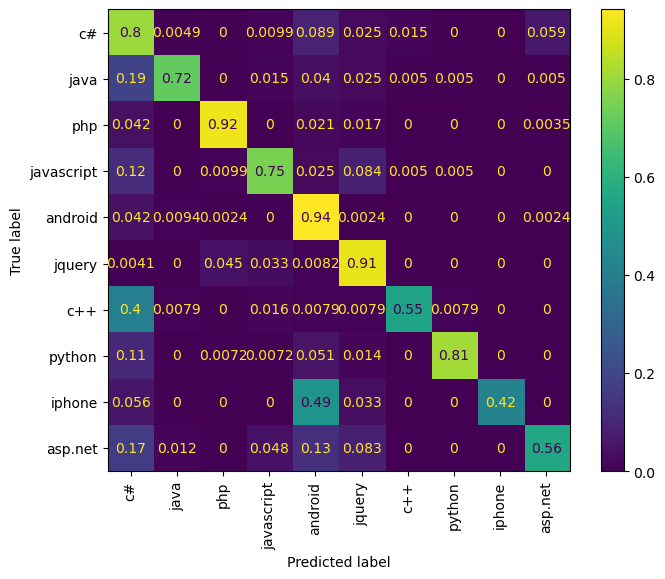

In [224]:
# Plot a confusion matrix to visualize the model's classification performance on the validation set.
# The matrix shows the true labels versus the predicted labels.
# The matrix is normalized by the number of true samples per class, making it easier to identify misclassifications.

fig, ax = plt.subplots(figsize=(8, 6))  # Initialize a plotting figure with a specified size.

# Generate and display the confusion matrix using true labels and predicted labels.
# The matrix is normalized, and custom display labels and x-axis tick rotation are applied for better visualization.
ConfusionMatrixDisplay.from_predictions(
    y_true=valid_labels,        # Actual labels from the validation set.
    y_pred=valid_preds,         # Predicted class labels by the model.
    ax=ax,                      # Plotting axis.
    normalize="true",           # Normalize by true class counts.
    display_labels=class_names, # Custom class names for display.
    xticks_rotation=90          # Rotate x-axis ticks for better readability.
)


In [225]:
# Log the confusion matrix to the Weights & Biases (Wandb) platform for monitoring and visualization.
# This allows for tracking the model's classification performance across different runs or iterations.

# log the Confusion Matrix to Wandb
wandb.log({
    "conf_mat": wandb.plot.confusion_matrix(
        preds=valid_preds,        # Model's predicted class labels.
        y_true=valid_labels,      # Actual labels from the validation set.
        class_names=class_names   # Custom class names for display in the confusion matrix.
    )
})



In [226]:
wandb.finish()


eval/accuracy,▁▄▅▅▇▇███████
eval/f1,▁▃▄▄▆▇▇▇█████
eval/loss,█▇▆▅▄▃▂▂▁▁▁▁▁
eval/runtime,▁▁▆▃▄█▇▅▄▅▅▅▆
eval/samples_per_second,██▃▆▅▁▂▃▅▄▄▄▃
eval/steps_per_second,██▃▆▅▁▂▃▅▄▄▄▃
train/epoch,▁▁▂▂▂▂▃▃▃▃▄▄▅▅▅▅▆▆▆▆▇▇████
train/global_step,▁▁▂▂▂▂▃▃▃▃▄▄▅▅▅▅▆▆▆▆▇▇█████
train/learning_rate,█▇▇▆▅▅▄▄▃▂▂▁
train/loss,█▇▆▅▄▃▃▂▂▂▁▂
train/total_flos,▁


### <font color = 'indianred'> **Check the best saved model**</font>


In [227]:
# After training, let us check the best checkpoint
# We need this for Predictions and Evaluations
best_model_checkpoint_step = trainer.state.best_model_checkpoint.split('-')[-1]
print(f"The best model was saved at step {best_model_checkpoint_step}.")


The best model was saved at step 240.


#  <font color = 'indianred'> **Inference**

## <font color = 'indianred'> **Test Set Evaluation**


In [228]:
# Create a subset of the test dataset ensuring equal representation from each label.
# This can be useful for testing a model's performance on a balanced dataset.

# test_subset = DatasetDict()  # Initialize an empty DatasetDict to store the subsetted data.

# texts = []  # List to accumulate sampled text data.
# labels = [] # List to accumulate corresponding labels for the sampled texts.

# # Iterate over each label from 0 to 9 (10 labels in total).
# for label in range(10):
#     # Filter out data samples in the 'test' split of test_dataset where the 'label' matches the current label.
#     # This provides all texts for the specific label.
#     label_texts = test_dataset['test'].filter(lambda x: x['label'] == label)['text']

#     # Randomly sample 200 texts from the filtered set.
#     label_subset = random.sample(list(label_texts), 200)

#     # Append the sampled texts to the 'texts' list.
#     texts.extend(label_subset)

#     # Append the corresponding label for each of the sampled texts to the 'labels' list.
#     labels.extend([label]*len(label_subset))

# # Construct a new dataset from the accumulated texts and labels and assign it to the 'test' split in test_subset.
# test_subset['test'] = Dataset.from_dict({'text': texts, 'label': labels})



In [229]:
test_subset

DatasetDict({
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

**NOTE we used ```from evaluate import evaluator``` in imdb dataset. Again this is currently not working for multiclass classification. Hence we will craete our own evaluator.**

In [230]:
def evaluator(model, dataset, tokenizer, compute_metrics, batch_size=16):
    """
    Evaluates a model's performance on a given dataset.

    Parameters:
    - model: The trained model to evaluate.
    - dataset: The dataset on which the model will be evaluated.
    - tokenizer: The tokenizer used to preprocess the text data.
    - compute_metrics: A function to compute evaluation metrics.
    - batch_size: Size of batches for evaluation. Default is 16.

    Returns:
    - evaluations: A dictionary containing computed evaluation metrics.
    """

    # Tokenize the dataset and truncate if the tokenized sequence is longer than the model's maximum input length.
    tokenized_dataset= dataset.map(lambda batch: tokenizer(batch["text"], truncation=True), batched=True)

    # Set the format of the tokenized dataset to be compatible with PyTorch.
    tokenized_dataset.set_format(type='torch')

    # Remove the 'text' column from the tokenized dataset as it's no longer needed post-tokenization.
    tokenized_dataset= tokenized_dataset.remove_columns(['text'])

    # Define a collation function that pads tokenized sequences to the same length for batching.
    collate_fn = DataCollatorWithPadding(tokenizer=tokenizer)

    # Initialize a DataLoader to iterate over the tokenized dataset in batches.
    datalaoder = DataLoader(tokenized_dataset, batch_size=batch_size, collate_fn=collate_fn)

    # Put the model in evaluation mode and move it to the GPU.
    model.eval()
    model.to('cuda')

    # Initialize variables to store the model's logits (raw prediction scores) and true labels.
    eval_logits = None
    eval_labels = None

    # Disable gradient calculations for efficient memory usage during evaluation.
    with torch.inference_mode():
        # Iterate over batches from the DataLoader.
        for batch in datalaoder:
            # Prepare the inputs and move them to the GPU.
            inputs = {k: v.to('cuda') for k, v in batch.items() if k != 'labels'}

            # Get the model's predictions for the current batch.
            outputs = model(**inputs)
            logits = outputs.logits
            labels = batch['labels'].to('cuda')

            # Append the logits and labels of the current batch to the accumulating variables.
            if eval_logits is None:
                eval_logits = logits.cpu().numpy()
                eval_labels = labels.cpu().numpy()
            else:
                eval_logits = np.append(eval_logits, logits.cpu().numpy(), axis=0)
                eval_labels = np.append(eval_labels, labels.cpu().numpy(), axis=0)

    # Compute evaluation metrics using the provided compute_metrics function.
    evaluations = compute_metrics((eval_logits, eval_labels))

    return evaluations


In [231]:
evaluations = evaluator(model, test_subset['test'], tokenizer, compute_metrics, batch_size=16)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [232]:
evaluations

{'f1': 0.7596763896803754, 'accuracy': 0.7915}

##  <font color = 'indianred'> **Pipeline for Predictions**

## <font color = 'indianred'> **Create pipelne for inference**

In [233]:
# Convert the path to the 'checkpoint-220' inside the 'model_folder' to a string format.
# SEE THE step number for best moel from the section -- Check the best saved model
# This was 220 for me, you might get a different numnber
checkpoint = str(model_folder/'checkpoint-220')

# Create a text classification pipeline using the Hugging Face's pipeline method.
# The pipeline is initialized with:
# - The task set to "text-classification".
# - Model and tokenizer both loaded from the specified checkpoint path.
# - Execution set to the primary device (typically the first GPU).

custom_pipeline = pipeline(
    task="text-classification",
    model=checkpoint,
    tokenizer=checkpoint,
    device=0)


Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


##  <font color = 'indianred'> **Prediction for individual or small list of examples**

In [234]:
sample = test_subset['test']['text'][0]
sample

'Type error in python! closedset = set()       root = (5,6)  for u,v in root:     if v is not closedset:        closedset.add(root)        print closedset  Error:  for u,v in root:  TypeError: unpack non-sequence  What should i do with type of error? '

In [239]:
preds = custom_pipeline(sample, truncation=True)
preds


[{'label': 'android', 'score': 0.8769351243972778}]

In [240]:
sample = test_split['text'][12]
sample

'How do i send an list item to the end of the list in android? My idea is to do a shopping list and when i click on an item it gets a strikethrough and goes to the end of the list. So far i have gotten everything except sending the item to the end of the list. Here is a bit of my code: protected void onListItemClick(ListView l, View v, int position, long id) {     // TODO Auto-generated method stub     super.onListItemClick(l, v, position, id);      TextView text = (TextView) v.findViewById(android.R.id.text1);     text.setPaintFlags(text.getPaintFlags() | Paint.STRIKE_THRU_TEXT_FLAG);  }  Edit: Thank you for the anwsers so far. Some helpful people requested more code so here is everything (including adding stuff to list): public class ShoppingActivity extends ListActivity {      ArrayList<String> list = new ArrayList<String>();     ArrayAdapter<String> adapter;      @Override     protected void onCreate(Bundle savedInstanceState) {         super.onCreate(savedInstanceState);         s

In [242]:
preds = custom_pipeline(sample, truncation = True)
preds

[{'label': 'android', 'score': 0.8769351243972778}]

## <font color = 'indianred'> **Prediction for large dataset**

In [243]:
predictions = custom_pipeline(test_subset['test']['text'], truncation=True)

In [244]:
predictions

[{'label': 'python', 'score': 0.4975731670856476},
 {'label': 'android', 'score': 0.8749161958694458},
 {'label': 'c#', 'score': 0.2084302455186844},
 {'label': 'php', 'score': 0.585583508014679},
 {'label': 'c#', 'score': 0.24162310361862183},
 {'label': 'jquery', 'score': 0.35606586933135986},
 {'label': 'php', 'score': 0.6782101392745972},
 {'label': 'php', 'score': 0.7110432982444763},
 {'label': 'android', 'score': 0.8756927847862244},
 {'label': 'java', 'score': 0.5232270359992981},
 {'label': 'c#', 'score': 0.28384512662887573},
 {'label': 'javascript', 'score': 0.6066387295722961},
 {'label': 'android', 'score': 0.8769351243972778},
 {'label': 'c#', 'score': 0.26210150122642517},
 {'label': 'javascript', 'score': 0.5996155142784119},
 {'label': 'android', 'score': 0.19203302264213562},
 {'label': 'c#', 'score': 0.43697553873062134},
 {'label': 'android', 'score': 0.4022851288318634},
 {'label': 'javascript', 'score': 0.3072473704814911},
 {'label': 'c#', 'score': 0.335519403219